In [1]:
import torch
from tqdm.notebook import tqdm
import sys
sys.path.append('../')

# Dataset

In [ ]:
from utils.dataloaders import get_split_cifar10_dataloaders

train_tasks_loaders, test_tasks_loaders = get_split_cifar10_dataloaders(batch_size=128, image_size=32, use_augmentations=True)

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Training

In [4]:
def train_task(model, hnet, optimizer, scheduler, criterion, dataloader, hnet_prev=None, task_embeddings=[]):
  model.train()
  hnet.train()

  train_loss = 0
  train_acc = 0

  for i, batch in enumerate(tqdm(dataloader)):
    pixels, labels = batch
    pixels = pixels.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    predicted_weights = hnet.get_task_weights(task_embeddings[-1]).to(device)
    output = model(pixels, predicted_weights)
    loss = criterion(output, labels)

    if hnet_prev:
      for t_e in task_embeddings[:-1]:
        loss += (1e-1 / len(task_embeddings[:-1])) * torch.sum((hnet_prev.get_task_weights(t_e) - hnet.get_task_weights(t_e)) ** 2)

    train_loss += loss.detach().item()
    train_acc += (output.argmax(dim=1) == labels).sum() / len(labels)
    loss.backward()

    optimizer.step()
    scheduler.step()
    

  return train_loss / len(dataloader), train_acc / len(dataloader)

In [5]:
def test_task(model, hnet, criterion, task_embedding, dataloader):
  model.eval()
  hnet.eval()

  test_loss = 0
  test_acc = 0

  for i, batch in enumerate(tqdm(dataloader)):
    pixels, labels = batch
    pixels = pixels.to(device)
    labels = labels.to(device)

    predicted_weights = hnet.get_task_weights(task_embedding).to(device)
    output = model(pixels, predicted_weights)

    loss = criterion(output, labels)

    test_loss += loss.item()
    test_acc += (output.argmax(dim=1) == labels).sum().item() / len(labels)


  return test_loss / len(dataloader), test_acc / len(dataloader)

In [6]:
import copy
from src.vit.custom.model import CustomViT
from src.hnet_lib.hnet import HyperNetwork
from utils.losses import CELabelSmoothedLoss

In [ ]:
TASK_COUNT = 5
n_epochs = 20
model = CustomViT(10, hyper_ln=True).to(device)
hnet = HyperNetwork(5, 128, model.get_weights_from_hnet_cnt()).to(device)
hnet_prev = None

optimizer = torch.optim.Adam(list(hnet.parameters()) + list(model.parameters()), lr=1e-3, betas=(0.9, 0.999), weight_decay=5e-5)
criterion = CELabelSmoothedLoss(10, 0.2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200, eta_min=1e-5)

task_embeddings = []
task_accuracies = []

for t in range(TASK_COUNT):
  print(f'TRAINING TASK {t + 1}\n')

  t_e = [0] * TASK_COUNT
  t_e[t] = 1
  task_embeddings.append(torch.tensor(t_e).type(torch.FloatTensor))
  
  train_losses = []
  for i in range(n_epochs):
    train_loss, train_acc = train_task(model, hnet, optimizer, scheduler, criterion, train_tasks_loaders[t], hnet_prev, task_embeddings)
    print(f'Epoch {i + 1}: {train_loss=} {train_acc=}')

  if t == 0:
    model.freeze()

  print(f'\nAFTER TRAINING TASK {t + 1}\n')

  accuracies = []
  for i in tqdm(range(t + 1)):
    test_loss, test_acc = test_task(model, hnet, criterion, task_embeddings[i], test_tasks_loaders[i])
    accuracies.append(test_acc)
    print(f'Task {i + 1}: {test_loss=} {test_acc=}')
  task_accuracies.append(accuracies)
    
  if hnet_prev:
    del hnet_prev

  hnet_prev = copy.deepcopy(hnet)

  print()

In [ ]:
task_accuracies_padded = [accs + [0] * (TASK_COUNT - len(accs)) for accs in task_accuracies].copy()

# Plots

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def plot_tasks_bar(task_accuracies, output_path, title=None, full_training_accuracy=None):
    task_accuracies = np.array(task_accuracies).T * 100

    tasks = {
        '0-1': task_accuracies[0],
        '2-3': task_accuracies[1],
        '4-5': task_accuracies[2],
        '6-7': task_accuracies[3],
        '8-9': task_accuracies[4],
    }

    x = np.arange(1, len(tasks) + 1)
    width = 0.2
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    handles = []

    for attribute, measurement in tasks.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        handles.append(rects)
        multiplier += 1

    ax.set_ylabel('Accuracy (%)')
    ax.set_xlabel('Выучено контекстов')
    if title is not None:
        ax.set_title(f'{title}')


    if full_training_accuracy is not None:
      hline = ax.hlines(full_training_accuracy * 100, 0.92, 5.88, color='black',
                        linestyle='--', linewidth=2, label='Полное обучение')
      handles.append(hline)

    ax.legend(handles=handles, loc='best', ncols=3, fontsize=13)
    ax.set_ylim(0, 120)

    ax.locator_params(axis='y', nbins=20)

    xticks = ax.xaxis.get_major_ticks()
    xticks[-2].label1.set_visible(False)
    xticks[-1].label1.set_visible(False)
    
    yticks = ax.yaxis.get_major_ticks()
    yticks[-1].label1.set_visible(False)
    yticks[-2].label1.set_visible(False)

    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)

    ax.tick_params(axis='both', which='major', labelsize=16)

    fig.savefig(output_path, dpi=300, bbox_inches='tight')

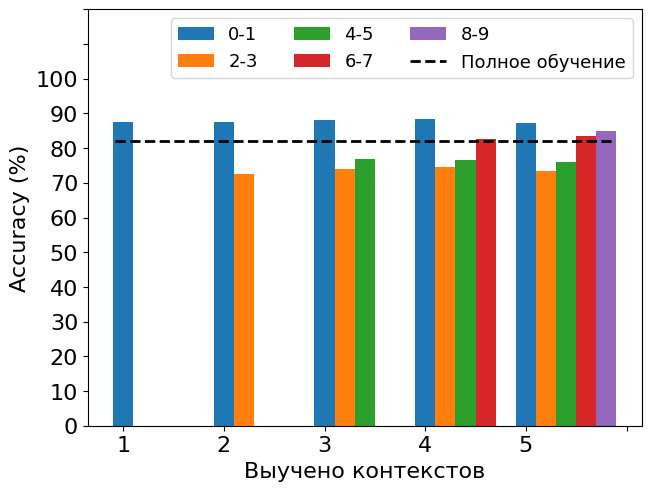

In [29]:
plot_tasks_bar(task_accuracies_padded, '../experiments/custom-vit/plots/custom-vit-hnet-ln', full_training_accuracy=0.82)